# Тестирование на примере метрик-отношений

*Подготовил Ян Пиле*

См.видео: https://www.youtube.com/watch?v=ObzlKVCiBqI /юб/

Сегодня мы сконцентрируемся на применении большого набора различных методов к одной задаче: проведении A/B теста с показами баннеров. Представим, что у нас есть две модели показа баннеров пользователям. Чем больше они в баннеры кликают, тем больше мы заработаем :) Стало быть, наша задача увеличить среднее количество кликов, которое сделает пользователь в группе 
$$CPU = \frac{1}{|Users|}\sum_i{clicks_i}\text{ }\text{, здесь CPU - clicks per user}$$

Мы будем считать, что у нас есть хорошая система сплитования пользователей (разбиения пользователей на группы) и в группах абсолютно одинаковое количество пользователей. Давайте посмотрим, как мы могли бы устроить процесс сравнения кликов в целевой и контрольной группах.

## Гипотезы

Наши гипотезы выглядят так:

**Нулевая гипотеза**    $H_0: CPU_1 = CPU_2$

**Альтернативная гипотеза**     $H_1: CPU_1  \not= CPU_2$ (Двусторонняя альтернатива)

Теперь нужно каким-то образом выбрать тест, с помощью которого мы будем проверять гипотезу. Любой тест можно охарактеризовать такими величинами как:

**False Positive Rate** - вероятность ошибки первого рода или вероятность отклонения верной нулевой гипотезы. Если ваша процедура проверки гипотез, сплитование и т.д. устроены так как нужно, эта ошибка сверху должна ограничиваться уровнем значимости или p-value.

**Чувствительность (Sensitivity)** - вероятность отклонения неверной нулевой гипотезы. Эта штука уже в явном виде не ограничена.

Нетрудно представить два крайних случая: Если мы всегда будем принимать нулевую гипотезу(вне зависимости от ее правдивости) мы получим нулевой **False Positive Rate**, с другой стороны – если мы всегда будем отвергать нулевую гипотезу в пользу любой альтернативы, мы получим критерий со стопроцентной **чувствительностью**, естественно, в народном хозяйстве такая процедура совершенно бесполезна и в реальной жизни выбор теста - всегда компромисс между вероятностью ошибки первого рода и чуствительностью. 

Обычно зависимость **False Positive Rate** от **чувствительности** имеет такой вид:

<img src="sample CDF.png" width="500">

Наша задача сделать так, чтобы график был как можно ближе к левому верхнему углу. Если вы уже что-то знаете про машинное обучение, в этом рисунке можно угадать ROC-кривую. Не пугайтесь, если не знаете, что это, мы обязательно обсудим это потом. Мы предположили, что наш эксперимент проведен правильно, никаких проблем с ним нет и тогда **False Positive Rate** ограничен сверху нашим уровнем значимости. Часто тесты принимаются на уровне 0.05. Давайте попробуем сранивать наши различные методы по чувствительности на уровне значимости 0.05. Как раз мы успеем понять, какие методы лучше, а какие хуже для этой конкретной задачи. Будем говорить, что если **чувствительность** одного теста на уровне 0.05 выше, чем чувствительность другого теста, то он **мощнее**. А чувствительность на уровне 0.05 в рамках нашей лекции будем называть мощностью (хотя в общем случае мощность и чувствительнось – $\pm$ одинаковые понятия)



## От чего зависит мощность теста

Мощность теста зависит от:

    1) Типа теста
    2) Распределения данных
    3) Размера эффекта
    4) Размера тестовых групп

Мы попробуем смоделировать какой-то разумный вид измеряемых нами параметров и провести исследование того, как различные тесты будут себя вести в зависимости от изменения этих параметров.

Для начала оговорим то, с помощью каких распределений мы будем моделировать наши величины.
У нас есть две одинаковые группы пользователей. Одной группе мы покажем один набор баннеров, а другой - другой набор. Каждый пользователь в каждой из групп, соответственно, описывается количеством просмотров баннеров, которые он совершил и количеством кликов в эти баннеры. Можно немного формализовать это. Будем считать, что каждый пользователь обладает неким истинным $CTR$ или вероятностью того, что он кликнет в показанный ему баннер. Показы баннеров кажется разумным моделировать с помощью логнормального распределения - оно скошено влево и следовательно большая часть пользователей посмотрит мало баннеров, но некоторые посмотрят много (это довольно логичное предположение). Выглядит это так:

In [38]:
import numpy as np
import seaborn as sns
import scipy
from scipy.stats import norm, probplot, rankdata
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from typing import Tuple, Dict, Optional, Set, List
import os

## Генерируем распределения просмотров

Для логнормального распределения мы попробуем $\mu = 1$, $\sigma^2 = 1.5$, количество экспериментов равно 1000, а выборка имеет длину 5000.

Рекомендую посмотреть, какой параметр за что в распределении отвечает (в наших экспериментах мы будем варьировать $\sigma^2$, но менять $\mu$ тоже не возбраняется - в конце концов здесь мы хотим посмотреть на модель того, как выглядят просмотры.

In [39]:
mu = 1
sigma2 = 1
N = 5000
experiments = 1000
views_A = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)

Text(0.5, 1.0, 'Views, 99%-ile = 28.0   ')

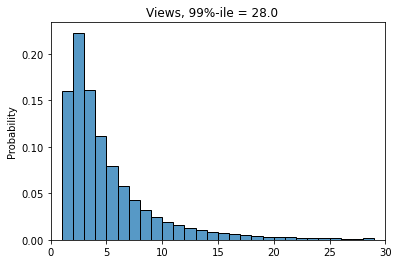

In [40]:
fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(views_A.ravel(),  # Теперь это массив длины experiments * N
                           bins=range(0, 30),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 30))
views_99_percentile = np.percentile(views_A.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

Скошенность распределения можно контролировать с помощью параметра $\sigma^2$

## Генерируем распределение ctr

Далее мы с вами договорились, что у каждого пользователя есть некий свой $CTR$. Сэмплировать его мы будем из Бета-распределения. Оно является ограниченным (принимает значения из промежутка от нуля до единицы), а это именно то, что нам и нужно :) Мы зафиксируем **среднее значение** этого распределения и будем называть его **success rate** или конверсией (из просмотров в клики) и будем менять дисперсию нашего бета распределения. При нулевой дисперсии истинный CTR в группе у всех будет одинаковым, а с ростом дисперсии пользователи будут становиться более "разношерстными" внутри группы. Дисперсией при фиксированном среднем будет управлять параметр $beta$. Заранее предположим, что конверсия в группах нашего АБ-теста отличается на некоторую величину, которую мы хотим "поймать" с помощью нашей статистической процедуры. Назовем эту величину дополнительного эффекта **uplift**. Тогда:

$$success\_rate_{treatment} = success\_rate_{control}(1+uplift)$$

In [41]:
success_rate = 0.02
beta = 1000
alpha = success_rate * beta / (1 - success_rate)

success_rate_A = scipy.stats.beta(alpha, beta).rvs(
    experiments * N).reshape(experiments, N)

Вы возможно спросите, откуда взялось такое значение alpha. Мы выбрали alpha в таком виде, чтобы мат.ожидание нашего бета-распределения равнялось success_rate. Для произвольных альфа и бета математическое ожидание бета-распределения равно:

$$E(X) = \frac{\alpha}{\alpha+\beta}$$

In [42]:
# Мы выбрали правильно :)
alpha/(alpha+beta)

0.02

Text(0.5, 1.0, 'Ground truth user CTR, std = 0.004')

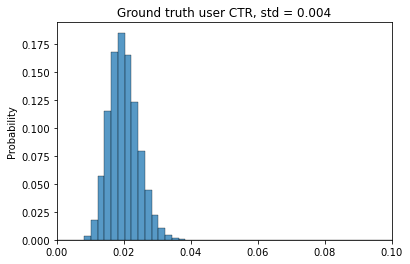

In [43]:
fig = plt.figure()
ax_ctr = fig.add_subplot()
sns.histplot(success_rate_A.ravel(),
             bins=np.linspace(0, 0.2, 100),
             ax=ax_ctr,
             kde=False,
             stat='probability')
ax_ctr.set_xlim((0, 0.1))
success_rate_std = success_rate_A[:10].flatten().std()
ax_ctr.set_title(f'Ground truth user CTR, std = {success_rate_std:2.3f}')

## Генерируем распределение кликов

Ну а распределение кликов для пользователей можно моделировать как биномиальное распределение для $views$ испытаний с с вероятностью успеха $ctr$:

$$clicks \sim Binomial(views, ctr)$$

С биномиальным распределением мы знакомы. Выглядеть это будет так:

In [44]:
clicks_A = scipy.stats.binom.rvs(views_A, success_rate_A)

# Сколько кликов было максимум
clicks_A.max()

14

(0.0, 10.0)

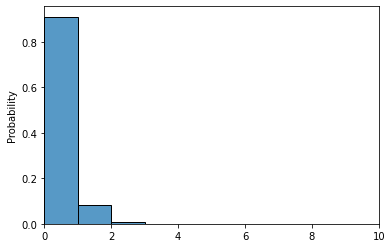

In [45]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(clicks_A.ravel(),  # Теперь это массив длины experiments * N
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))

## Соберем в кучу процесс генерации данных

    1) Задаем размер тестовой и контрольной групп (у нас он будет одинаковым. Это позволит использовать t-тест)
    2) Генерируем для теста и контроля распределение просмотров с помощью одного и того же логнормального
        распределения (это означает, что мы нашим тестом не влияем на просмотры, а влияем только на клики)
    3) Генерируем истинный ctr каждого пользователя из бета-распределений со средним равным success_rate для
        контрольной группы и средним равным success_rate*(1+uplift) для тестовой группы
    4) Для каждого пользователя генерируем количество просмотров из биномиального распределения с views
        испытаний и success_rate или success_rate*(1+uplift) вероятностью успеха соответственно
        
Если один раз таким образом сгенерировать данные, мы получим выборки для одного синтетического A/B-теста. А в процессе выше мы ввели две переменные, чтобы генерировать *experiments* синтетических А/В-тестов с выборками длины *n*.

# Проверка того, как работает наш тест

Мы сгенерировали *experiments* синтетических А/Б тестов. В них нам совершенно точно известно, что нулевая гипотеза НЕ верна (потому что есть ненулевой uplift). Давайте выберем какой-либо статистический тест (например t-тест для среднего количества кликов в группах. Заодно и проверим, как он работает при отклонениях от нормальности), применим его на каждом из наших синтетических тестов и получим тем самым выборку из *experiments* достигаемых уровней значимости (p-value). Если бы тест работал идеально, все p-value оказались бы нулями. В реальности мы получим какое-то распределение p-value. Посмотрим на кумулятивную функцию распределения наших p-value, напоминаю, что для выборки это функция на интервале от 0 до 1 равная "доле p-value, которые меньше или равны х". 

## Мы сделали 1000 синтетических А/Б тестов по 5000 пользователей.

Смотрим на QQ-график данных о кликах:

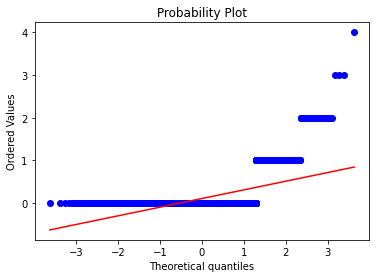

In [46]:
f = probplot(np.random.choice(clicks_A.ravel(),5000), dist="norm",plot=plt)

Как видите, данные вообще не нормальные. 

## Сгенерируем данные для тестовой группы ( uplift = 20%)

In [47]:
uplift = 0.2
views_B = np.absolute(np.exp(norm(mu, sigma2).rvs(experiments * N)).astype(np.int64).reshape(experiments, N) + 1)
alpha_B = success_rate * (1 + uplift) * beta / (1 - success_rate * (1 + uplift))
success_rate_B = scipy.stats.beta(alpha_B, beta).rvs(experiments * N).reshape(experiments, N)
clicks_B = scipy.stats.binom(n=views_B, p=success_rate_B).rvs()

# t-тест на количестве кликов 

Ниже приведена функция, которая по данным *experiments* синтетических тестов по *N* человек получает массив из *N* p-values. По ним мы посмотрим распределение и построим кумулятивную функцию распределения. 

In [48]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: scipy.stats.ttest_ind(
        x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

## Получили список p-value

Построим гистограмму p-values, а затем построим их кумулятивную функцию распределения.

In [49]:
p_values = t_test(clicks_A, clicks_B)

(0.0, 1.0)

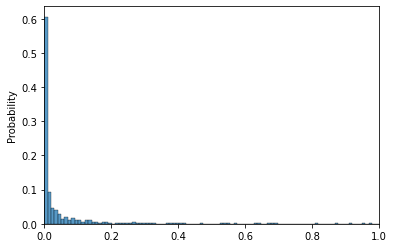

In [50]:
fig, axes = plt.subplots(ncols=1, nrows=1)
p_values_distr = sns.histplot(p_values,  # Теперь это массив длины experiments * N
                              bins=np.linspace(0, 1, 100),
                              kde=False,
                              ax=axes,
                              stat='probability')
axes.set_xlim((0, 1))

БОльшая часть p-values находится на гистограмме слева, это означает, что при справедливости альтернативной гипотезы (uplift $\not =$ 0) бОльшая часть тестов отличие регистрирует. Если нарисовать кумулятивную функцию распределения, то каждая ее точка будет показывать "какая доля тестов зарегистрировала отличие при условии того, что отличие есть". Этот показатель мы называли чувствительностью :) FPR в экспериментах ограничен p-value, то есть кумулятивная функция распределения показывает нам график зависимость **Чувствительности** от **FPR**.

Ниже приведена вспомогательная функция, рисующая график кумулятивной функции распределения наших p-value.

In [51]:
# Палитра цветов
colors = sns.color_palette("deep")


def plot_cdf(data: np.ndarray, label: str, ax: Axes, color: str = colors[0], linewidth=3):
    sorted_data = np.sort(data)
    position = scipy.stats.rankdata(sorted_data, method='ordinal')
    cdf = position / data.shape[0]

    sorted_data = np.hstack((sorted_data, 1))
    cdf = np.hstack((cdf, 1))

    return ax.plot(sorted_data,
                   cdf,
                   color=color,
                   linestyle='solid',
                   label=label,
                   linewidth=linewidth)

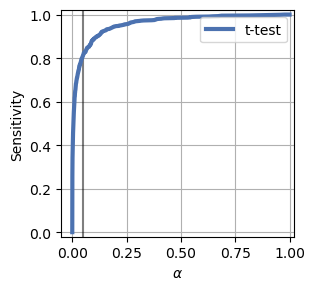

In [52]:
fig, ax = plt.subplots(figsize=(3, 3), dpi = 100)
gr = ax.grid(True)
xlim = ax.set_xlim(-0.05,1.02)
ylim = ax.set_ylim(-0.02,1.02)
ax.axvline(0.05, color='k', alpha=0.5)
cdf = plot_cdf(p_values,'t-test',ax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sensitivity')
legend = ax.legend()

Выше мы говорили, что **FPR** в экспериментах ограничен сверху **p-value**. На самом деле, это утверждение тоже может нарушаться. Наиболее распространенный случай, когда это может быть неверно, - когда допущения статистического теста нарушаются (например, нарушение нормальности для t-критерия). Важно отметить, что нарушение предположений необходимо, но недостаточно, чтобы испортить статистический тест. Если **p-value** достаточно хорошо контролирует **FPR**, тест даст правильные результаты, несмотря на нарушение предположений. Таким образом, для каждого статистического теста мы должны иметь возможность проверить, контролирует ли **p-value** **FPR**.

Сгенерируем для нашего А/B теста выборки с $uplift = 0$. В этом случае среднее число кликов должно быть идентичным, так как мы возьмем образцы тестовой и контрольной групп из одного и того же распределения, так что нулевая гипотеза будет верна. **p-value** будет правильно контролировать **FPR** тогда и только тогда, когда **p-value** имеет равномерное на [0, 1] распределение для A / A тестов. 

Давайте разберемся :) 

Рассмотрим пороговое **p-value** равное 0,05. Когда фактическое **p-value** меньше 0.05, мы отклоняем H0 и получаем ложноположительный результат (потому что для A/A-тестов $H_0$ верна). Утверждается, что в этом случае **FPR** равен нашему порогу по **p-value**, например для A/A-тестов **p-value** ниже порога 0,05 только в 5% случаев. Это как раз и есть требование однородности. 

После чего построим кумулятивную функцию распределения. Теперь нам точно известно, что группы одинаковые, то есть верна нулевая гипотеза. Тогда по оси Y будет отображаться доля неверно отклоненных нулевых гипотез, а это и есть **FPR**. В случае, если наш тест состоятелен, кумулятивная функция распределения будет выглядеть как диагональ единичного квадрата (то есть $FPR \simeq \text{p-value}$). 

In [53]:
uplift = 0
views_B = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)
alpha_B = success_rate * (1 + uplift) * beta / \
    (1 - success_rate * (1 + uplift))
success_rate_B = scipy.stats.beta(alpha_B, beta).rvs(
    experiments * N).reshape(experiments, N)
clicks_B = scipy.stats.binom(n=views_B, p=success_rate_B).rvs()

## p-values для А/А-теста

In [54]:
p_values = t_test(clicks_A, clicks_B)

(0.0, 1.0)

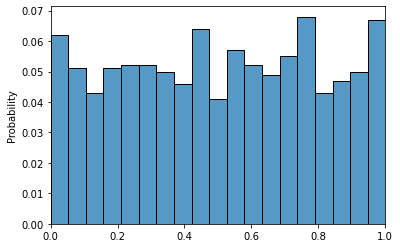

In [55]:
fig, axes = plt.subplots(ncols=1, nrows=1)
p_values_distr = sns.histplot(p_values, # Теперь это массив длины experiments * N 
                 bins=np.linspace(0, 1, 20),
                 kde=False,
                 ax = axes,
                 stat='probability')
axes.set_xlim((0, 1))

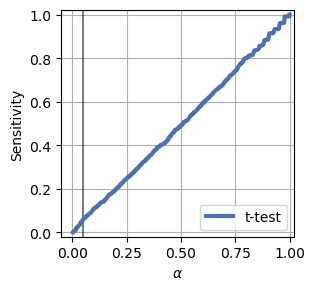

In [56]:
fig, ax = plt.subplots(figsize=(3, 3), dpi = 100)
gr = ax.grid(True)
xlim = ax.set_xlim(-0.05,1.02)
ylim = ax.set_ylim(-0.02,1.02)
ax.axvline(0.05, color='k', alpha=0.5)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sensitivity')
cdf = plot_cdf(p_values,'t-test',ax)
legend = ax.legend()

Завернем весь процесс генерации данных для А/А эксперимента и A/B эксперимента при заданных значениях параметров в одну функцию, которая будет выдавать три набора выборок: sample_a_1, sample_a_2 и sample_b.

In [57]:
def generation(N=5000,  # Кол-во человек в выборке
               experiments=2000,  # Кол-во синтетических экспериментов А/А и А/В
               # Один из параметров распределения просмотров (можете самостоятельно его пошатать)
               mu=1,
               # Скошенность распределения просмотров (можете самостоятельно его пошатать)
               sigma2=0.5,
               success_rate=0.02,  # Истинный CTR в контрольной группе
               uplift=0.2,  # Аплифт теста над контролем. По умолчанию 20%
               beta=1000  # Параметр для контроля дисперсии распределения истинного CTR
               ):

    # На просмотры мы не влияем, поэтому тут сэмплирование одинаковое
    # Но что будет, если мы влияем на просмотры?
    views_a_1 = np.exp(norm(mu, sigma2).rvs(experiments * N)
                       ).astype(np.int64).reshape(experiments, N) + 1
    views_a_2 = np.exp(norm(mu, sigma2).rvs(experiments * N)
                       ).astype(np.int64).reshape(experiments, N) + 1
    views_b = np.exp(norm(mu, sigma2).rvs(experiments * N)
                     ).astype(np.int64).reshape(experiments, N) + 1

    # Правит проблемы для случаев слишком большой скошенности
    views_a_1 = np.absolute(views_a_1)
    views_a_2 = np.absolute(views_a_2)
    views_b = np.absolute(views_b)

    # Истинный CTR для групп А/А
    alpha_a = success_rate * beta / (1 - success_rate)
    success_rate_a_1 = scipy.stats.beta(alpha_a, beta).rvs(
        experiments * N).reshape(experiments, N)
    success_rate_a_2 = scipy.stats.beta(alpha_a, beta).rvs(
        experiments * N).reshape(experiments, N)

    # Истинный CTR для группы В
    alpha_b = success_rate * (1 + uplift) * beta / \
        (1 - success_rate * (1 + uplift))
    success_rate_b = scipy.stats.beta(alpha_b, beta).rvs(
        experiments * N).reshape(experiments, N)

    # Распределение кликов в группах
    clicks_a_1 = scipy.stats.binom(n=views_a_1, p=success_rate_a_1).rvs()
    clicks_a_2 = scipy.stats.binom(n=views_a_2, p=success_rate_a_2).rvs()
    clicks_b = scipy.stats.binom(n=views_b, p=success_rate_b).rvs()

    return views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b

In [58]:
views_a_1, views_a_2, views_b,\
success_rate_a_1, success_rate_a_2, success_rate_b,\
clicks_a_1, clicks_a_2, clicks_b = generation()

Остается нарисовать кумулятивную функцию распределения и на ней затем отметить чувствительность при заданном $\alpha$

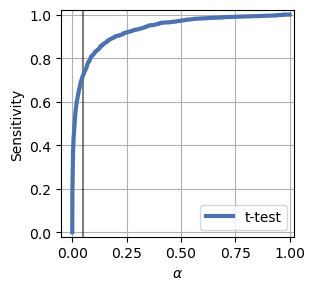

In [59]:
p_values = t_test(clicks_a_1, clicks_b)
fig, ax = plt.subplots(figsize=(3, 3), dpi = 100)
gr = ax.grid(True)
xlim = ax.set_xlim(-0.05,1.02)
ylim = ax.set_ylim(-0.02,1.02)
ax.axvline(0.05, color='k', alpha=0.5)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sensitivity')
cdf = plot_cdf(p_values,'t-test',ax)
legend = ax.legend()

Отлично. Теперь давайте в виде одной функции научимся рисовать несколько графиков:

    1) Кумулятивную функцию распределения для А/В тестов (по ней будем смотреть чувствительность)
    2) Кумулятивную функцию распределения для А/А тестов (по ней будем смотреть, что FPR <= p-value
    3) График просмотров 
    4) График истинного CTR пользователя 
    5) Столбиком будем рисовать мощность критерия - чувствительность на уровне 0.05

Такие графики нужно научиться строить для различных тестов и тогда мы сможем понять, в чем плюсы и минусы каждого из подходов.

Функция написана таким образом, что в нее можно подать набор названий тестов и набор названий функций, считающих эти тесты, а на графики выведутся соответствующие результаты.

In [60]:
colors = sns.color_palette("deep")

titles = ['t-test on clicks']
p_values_ab = [t_test(clicks_a_1, clicks_b)]
p_values_aa = [t_test(clicks_a_1, clicks_a_2)]
views = views_b
ground_truth_ctr = success_rate_a_1 
color = colors[0]

test_data = {}
for i,j in enumerate(titles):
    test_data[j] = (p_values_ab[i],p_values_aa[i],colors[i])

def plot_summary(data, #Сюда мы будем укладывать сгенерированные данные 
                 ground_truth_ctr,
                 views
                ):
    cdf_h1_title = 'p-value при справедливости H1 (Sensitivity)'
    cdf_h0_title = 'p-value при справедливости H0 (FPR)'
    
    # Делаем табличку 4*3 из графиков
    fig = plt.figure(constrained_layout=False, figsize=(3 * 3.5, 3.5 * 3), dpi = 100)
    gs = fig.add_gridspec(4, 3)
    
    # Распределяем графики по сетке
    ax_h1 = fig.add_subplot(gs[:2, :2]) # Чувствительность на А/В
    ax_h0 = fig.add_subplot(gs[0, 2]) # Контроль FPR на A/A
    ax_views = fig.add_subplot(gs[1, 2]) # Просмотры в контроле
    ax_clicks = fig.add_subplot(gs[2, 2]) # клики в контроле
    ax_powers = fig.add_subplot(gs[2, :2]) # Мощности сравниваемых критериев (чувствительность на 0.05)
    ax_fpr = fig.add_subplot(gs[3, :2]) # Контроль FPR при на уровне 0.05
    
    # Подгонка отображения 
    fig.subplots_adjust(left=0.2, wspace=0.3, hspace=0.4)
    
    # Нарисуем диагонали на гарфиках с p-value, чтобы удобнее было сравнивать
    ax_h1.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
    ax_h0.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)

    
    ax_h1.set_title(cdf_h1_title)
    ax_h0.set_title(cdf_h0_title)

    # ax_h1.set_ylabel('Sensitivity')
    # ax_h0.set_ylabel('FPR')

    ax_h1.axvline(0.05, color='k', alpha=0.5)
    # ax_h1.set_xticks(list(ax_h1.get_xticks()) + [0.05])
    
    # Рисуем графики p-value для А/А и А/B для всех тестов
    for title, (ab_pvals, aa_pvals, color) in data.items():
        plot_cdf(ab_pvals, title, ax_h1, color, linewidth=3)
        plot_cdf(aa_pvals, title, ax_h0, color, linewidth=1.5)
    
    ax_h1.grid(True)
    ax_h0.grid(True)
    
    ax_powers.set_title('Test Power')
    ax_fpr.set_title(r'False Positive rate для $\alpha = 0.05$')
    tests_powers = []
    tests_fprs = []
    tests_labels = []
    tests_colours = []
    
    for title, (ab_pvals,aa_pvals, color) in data.items():
        tests_labels.append(title)
        tests_colours.append(color)
        tests_powers.append(np.mean(ab_pvals < 0.05))
        tests_fprs.append(np.mean(aa_pvals < 0.05))
    ax_powers.barh(np.array(tests_labels), np.array(tests_powers), color=np.array(tests_colours))        
    ax_fpr.barh(np.array(tests_labels), np.array(tests_fprs), color=np.array(tests_colours))

    sns.histplot(views.ravel(),
                 bins=range(0, 20),
                 ax=ax_views,
                 kde=False,
                 stat='probability').set(ylabel=None)
    ax_views.set_xlim((0, 20))
    views_99_percentile = np.percentile(views[:100].ravel(), 99)
    ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

    sns.histplot(ground_truth_ctr[:10].ravel(),
                 bins=np.linspace(0, 0.2, 100),
                 ax=ax_clicks,
                 kde=False,
                 stat='probability').set(ylabel=None)
    ax_clicks.set_xlim((0, 0.1))
    success_rate_std = ground_truth_ctr[:100].flatten().std()
    ax_clicks.set_title(f'Истинный CTR, std = {success_rate_std:2.3f}')
    plt.close() # Это чтобы функция не выплевывала картинку по умолчанию
    return fig

В ячейке выше использованы всякие функции для рисования :) Поэтому вот глоссарий:

**plt.figure** - создание области рисунка, полный список параметров [тут](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)\
**fig.add_gridspec** - сделать "сетку", на которой можно нарисовать графики разного размера, обучатор [тут](https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py)\
**fig.subplots_adjust** - делаем так, чтоб графики не были слишком близко друг к другу, описание параметров [тут](https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py)\
**plt.barh** - горизонтальная гистограмма (у нас там стат.мощность отображается) [тут](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html)\
**seaborn.histplot** - Рисуем гистограмму, полный список параметров [тут](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot)

# Т-тест на кликах

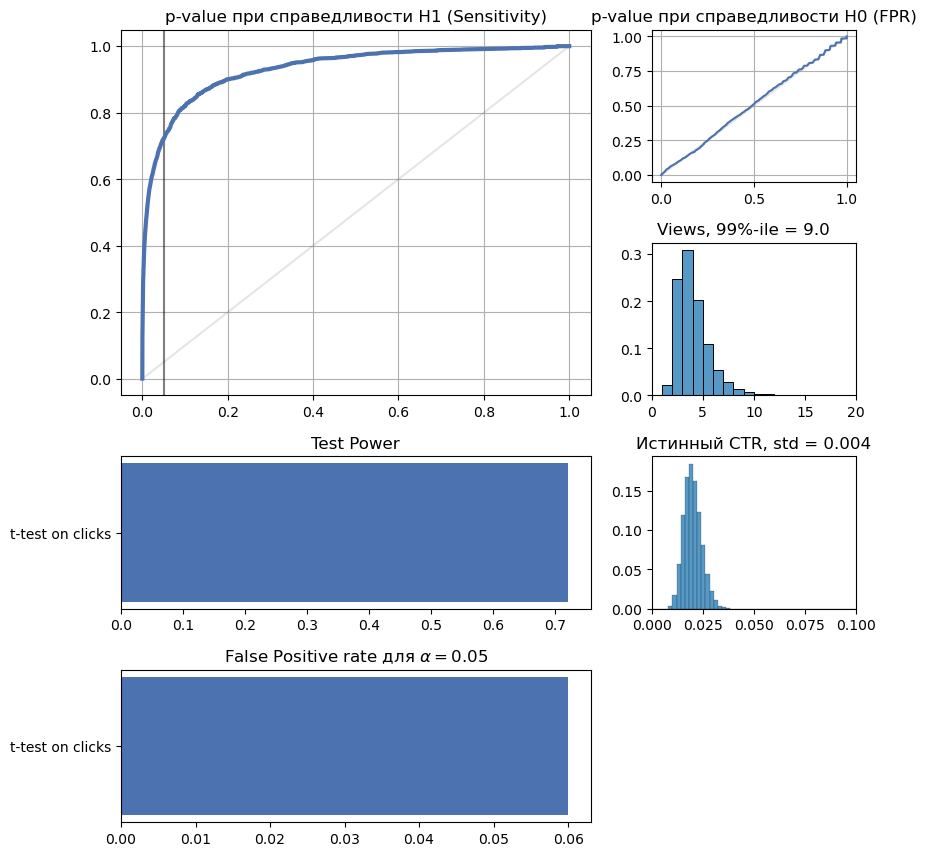

In [61]:
x = plot_summary(test_data,ground_truth_ctr,views)
x

Что ж, мы разобрались с "рисовалкой", осталось разобраться с тестами. Предложим разные методы оценки и параллельно будем менять вид наших распределений. Тем самым, попробуем понять, что лучше, а что хуже и в каком случае.

Предлагаю для начала "пошатать" то, насколько скошено наше распределение просмотров. Как вы помните, отвечает за это параметр $\sigma^2$

Поначалу будет: \
**uplift** = 20% ,\
**ctr_control** = 0.02,\
**beta** = 1000,\
**N**=5000,\
**experiments**=2000,\
**mu**=1

In [25]:
for sigm2 in [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 1.2, 1.5, 1.7, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]:
    views_a_1, views_a_2, views_b,\
    success_rate_a_1, success_rate_a_2,success_rate_b,\
    clicks_a_1, clicks_a_2, clicks_b = generation(sigma2 = sigm2)
    titles = ['t-test on clicks']

    p_values_ab = [t_test(clicks_a_1, clicks_b)]
    p_values_aa = [t_test(clicks_a_1, clicks_a_2)]

    views_target = views_b
    ground_truth_ctr_target = success_rate_b 
    color = colors[0]
    titles = ['t-test on clicks']

    test_data = {}
    for i,j in enumerate(titles):
        test_data[j] = (p_values_ab[i],p_values_aa[i],colors[i])
    pict = plot_summary(test_data,ground_truth_ctr_target,views_target)
    name = f'experimens={2000}_sample_size={5000}_uplift={0.2}_success_rate={0.02}_beta={1000}_skew={sigm2}.png'
    pict.savefig(f'{name}')

Сохраним gif для изменения чувствительности t-теста в gif

In [26]:
gif_list = sorted([i for i in os.listdir() if '.png' in i and 'exp' in i])

In [35]:
gif_list

[]

Уложим наши графики в GIF

In [34]:
from PIL import Image
import imageio

frames = []
for i in gif_list:
    new_frame = Image.open(i)
    frames.append(new_frame)

frames[0].save('t_test_vs_views.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=800, loop=0)
# Удалим картинки
for i in gif_list:
    os.remove(i) 

<img src="t_test_vs_views.gif" width="800">

# Тест Манна-Уитни на кликах

Что мы видим? Т-тест начинает плохо работать при сильном перекосе в распределении просмотров. Тут нам должен помочь тест Манна-Уитни, мы в одной из лекций обсуждали, что он к распределению не слишком чувствителен. Единственное требование - для бОльшей части наблюдений не должно быть абсолютно одинаковым.

* Плюсы: нет проблем с распределением 
* Минусы: не сравнивает средние/медианы или что-то подобное, вычислительно сложный

Еще раз:
Нужно быть осторожным: если подавляющее большинство пользователей в вашем наборе данных не кликнули ни разу, тест MW на ваших данных "не заведется". Описание можно найти [тут](https://www.tandfonline.com/doi/full/10.1080/00031305.2017.1305291)

In [26]:
def mannwhitney(a, b):
    """
    Двусторонний тест Манна-Уитни
    :param a: np.array вида (n_experiments, n_users), значения метрики в контроле
    :param b: np.array вида (n_experiments, n_users), значен я метрики в тесте
    :return: np.array вида (n_experiments), двусторонние p-value методом Манна-Уитни для всех экспериментов
    """
    result = list(map(lambda x: scipy.stats.mannwhitneyu(
        x[0], x[1], alternative='two-sided').pvalue, zip(a, b)))
    return np.array(result)

## Функция удаления картиночек

In [27]:
def del_png(gif_list):
    for i in gif_list:
        os.remove(i)

## Функция заворачивания в GIF

In [28]:
def to_gif(png_list, gif_name):
    frames = []
    for i in png_list:
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save(gif_name, format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=800, loop=0)

# Меняем скошенность

<img src="t_test_and_Mann_Whitney.gif" width="800">

Что здесь можно увидеть? Тест Манна-Уитни начинает обыгрывать Т-тест, когда распределение кликов сильно перекошено. Все дело в том, что t-тест работает в предположении нормальности, а мы с вами его начали портить. Мы только что "перекосили" распределение кликов, "пошатав" скошенность распределения просмотров. Еще одним источником "проблем" t-теста может стать распределение истинного CTR. Если в вашей группе находятся пользователи с очень РАЗНЫМИ вероятностями клика (большая диверсификация aka большая дисперсия), этот разброс в CTR испортит вам распределение кликов. Будем менять $\beta$, оставив $\sigma^2 = 1$. Выглядеть будет так:

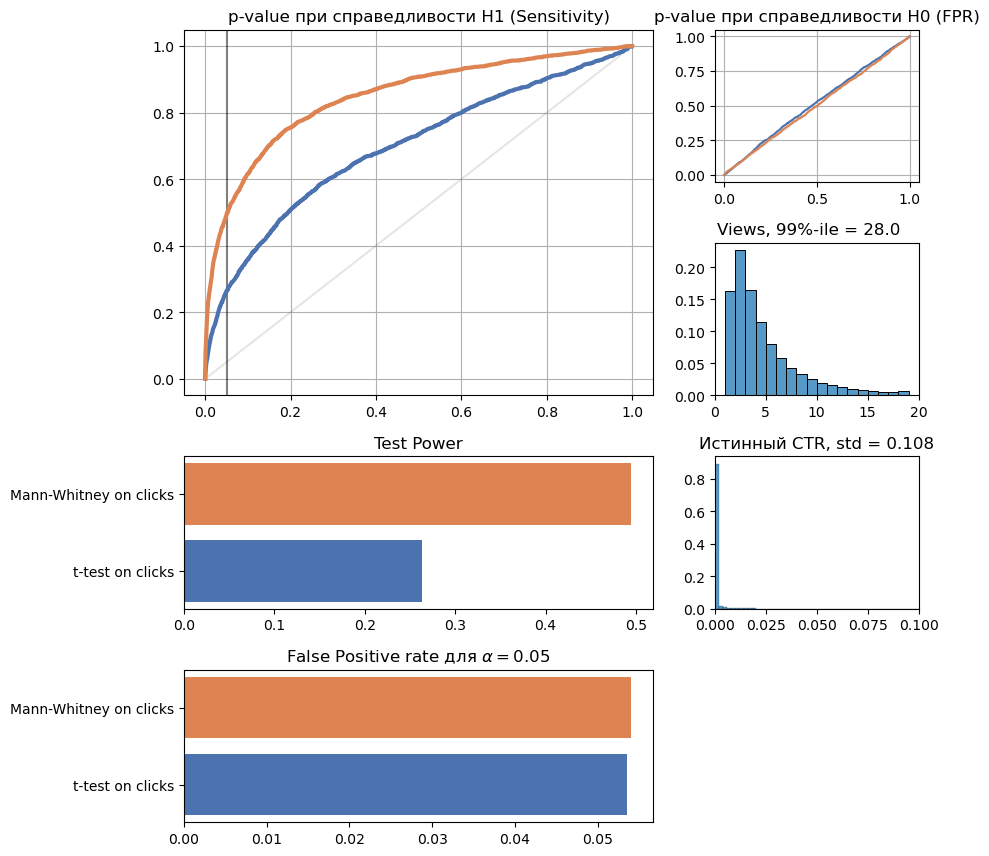

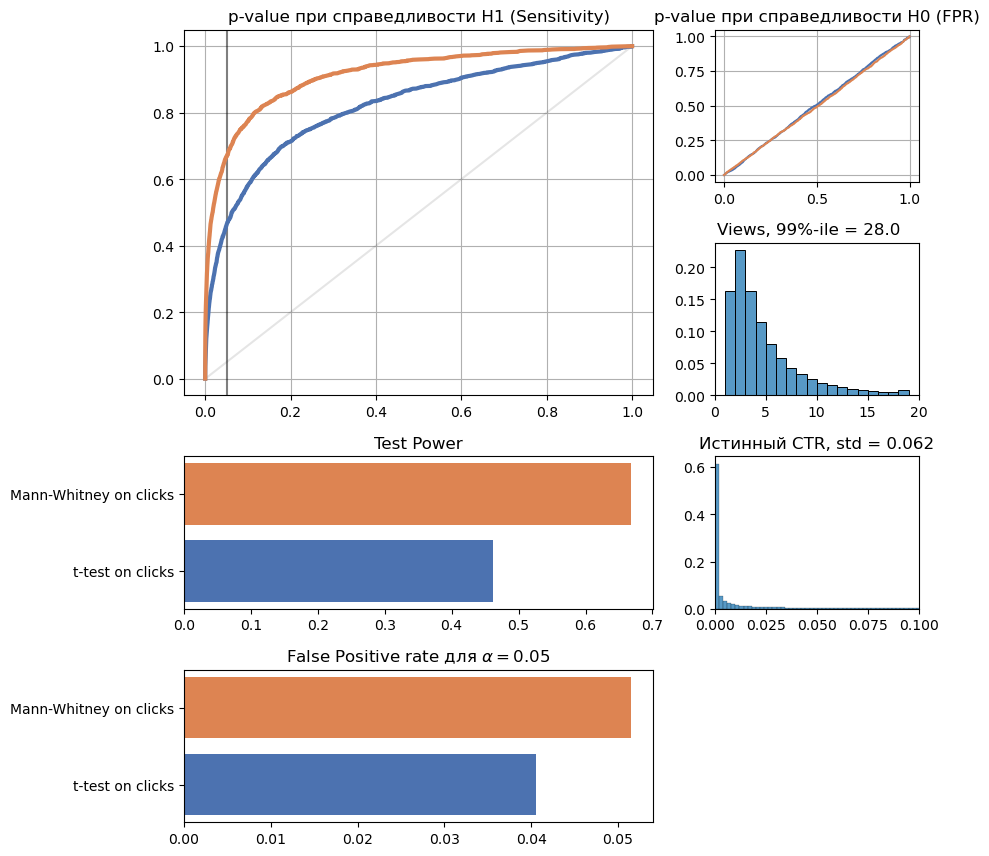

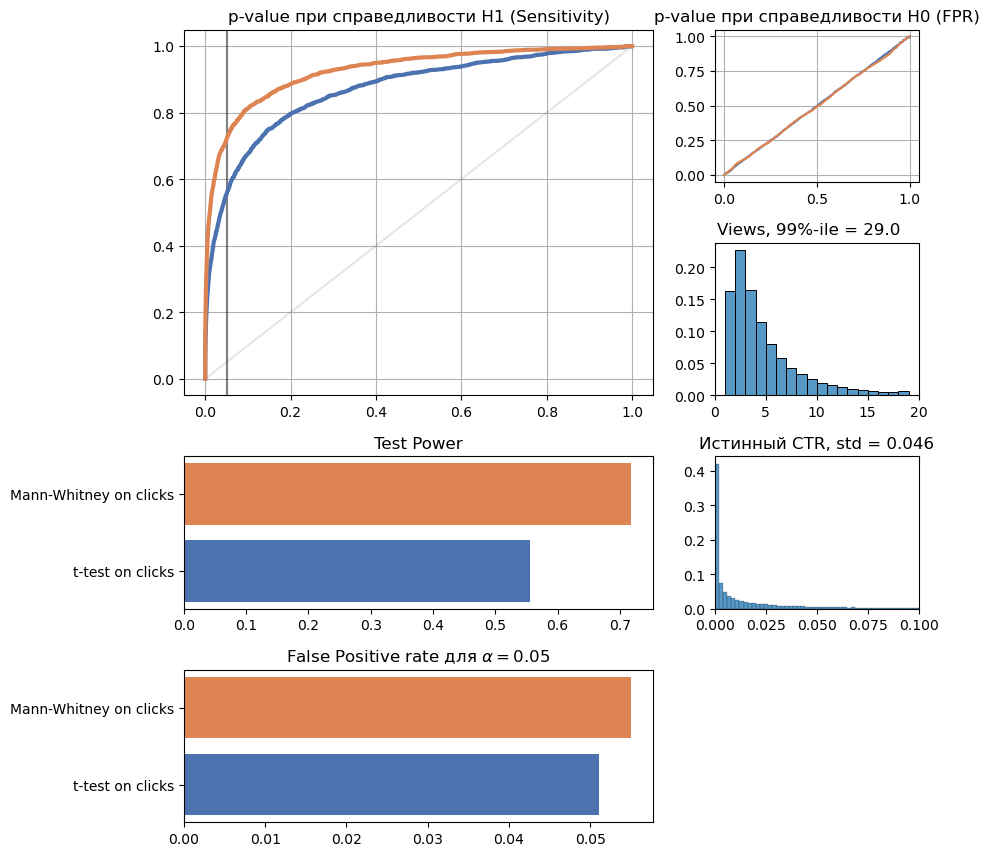

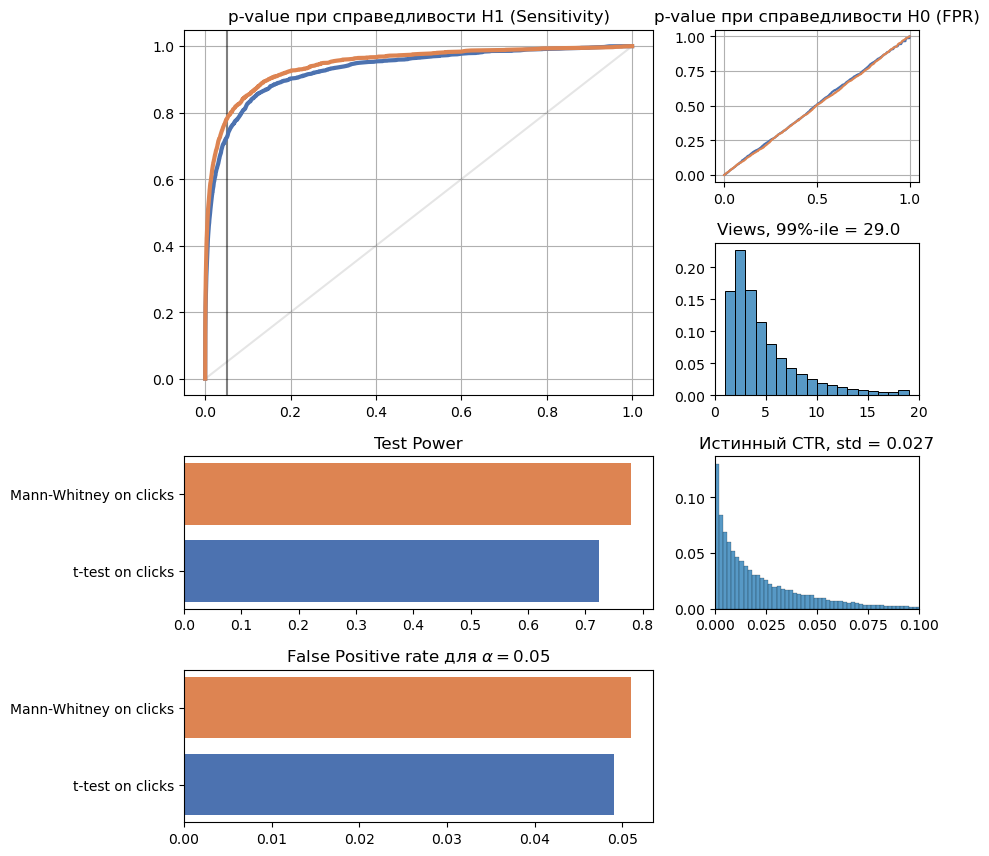

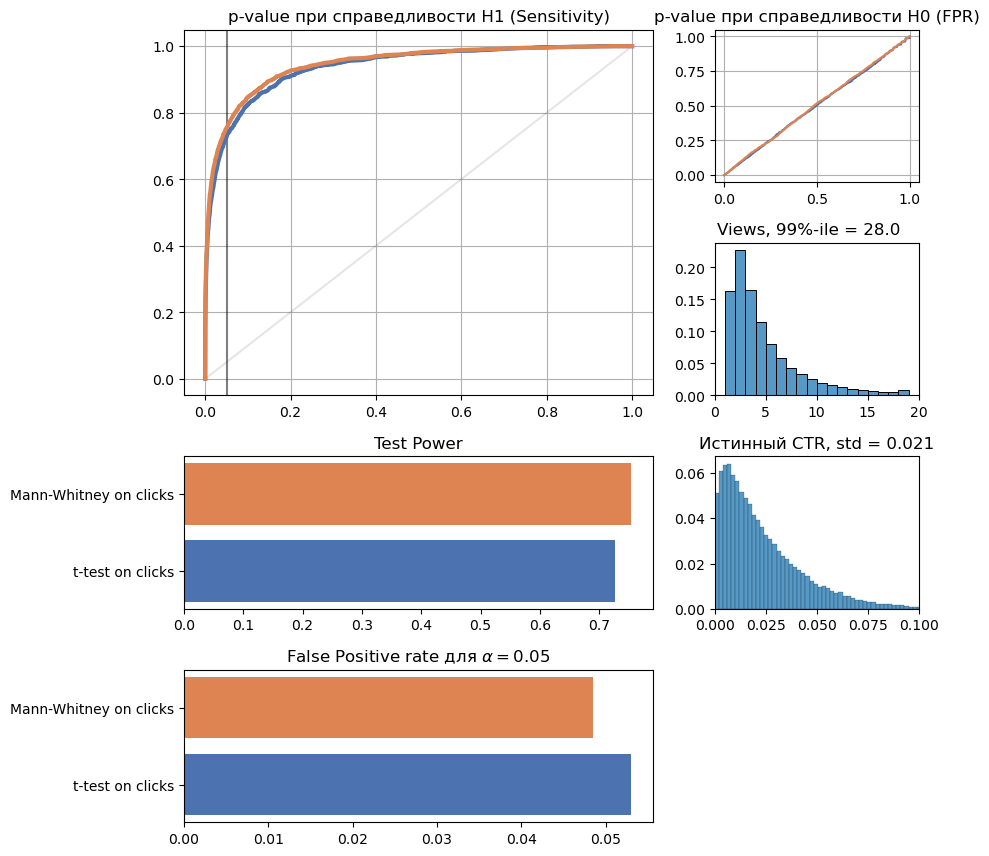

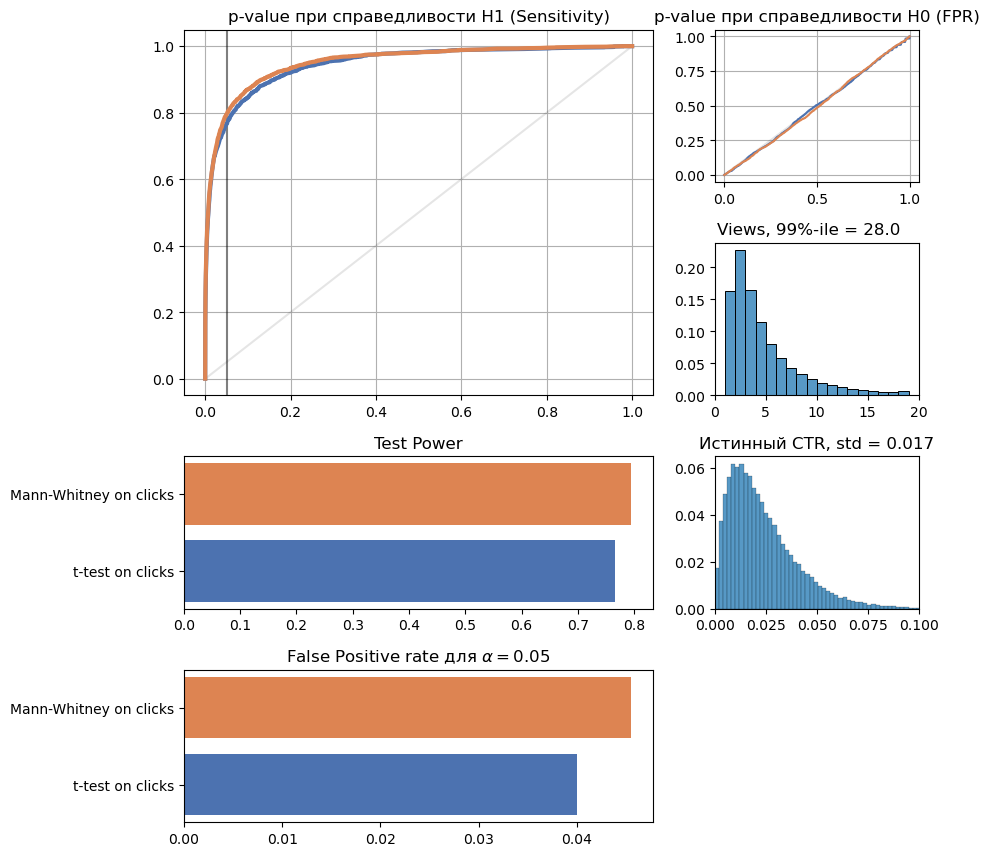

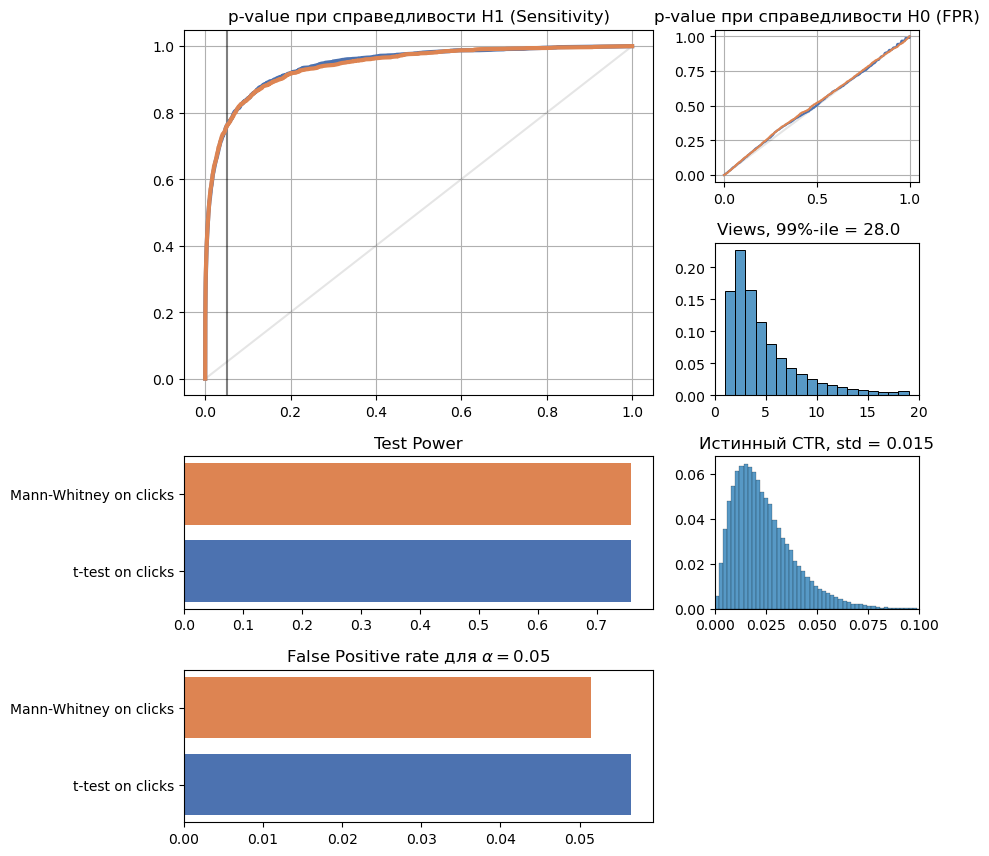

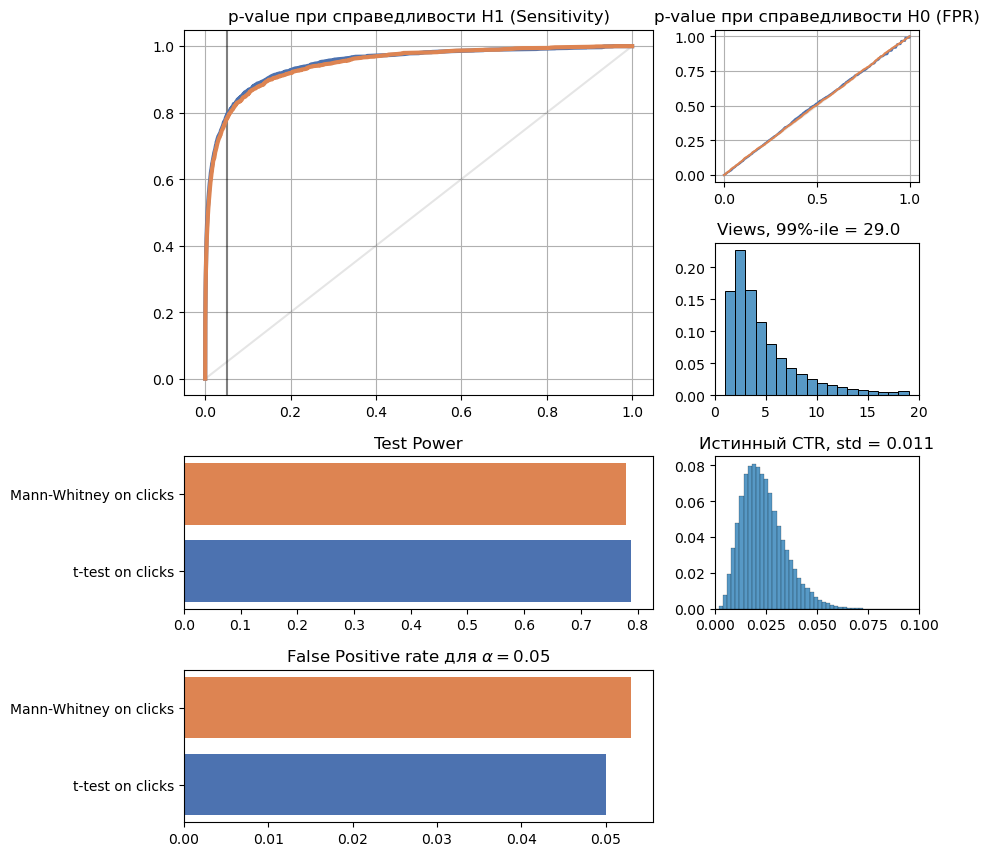

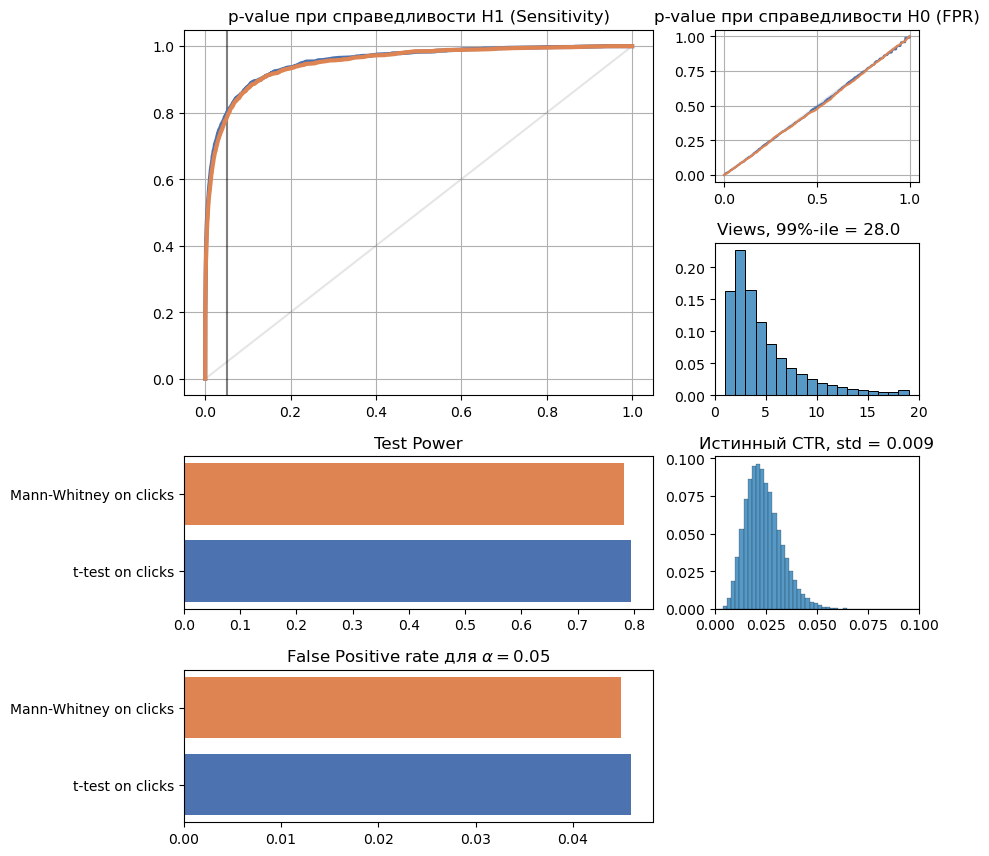

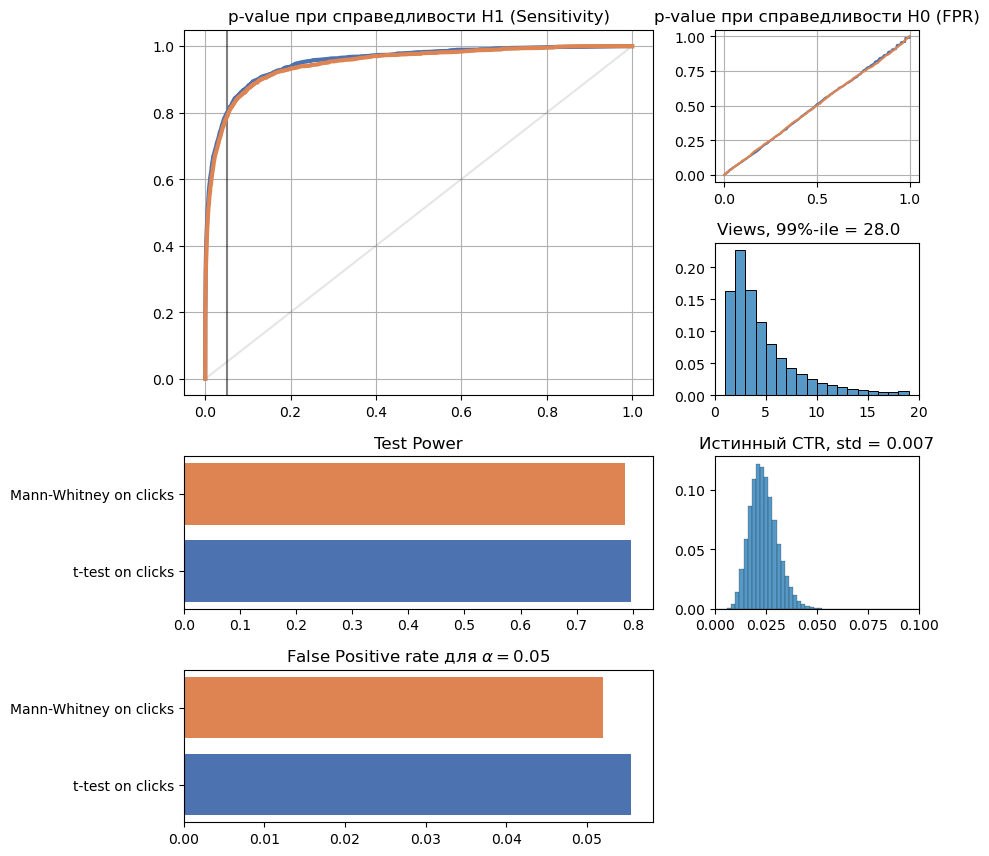

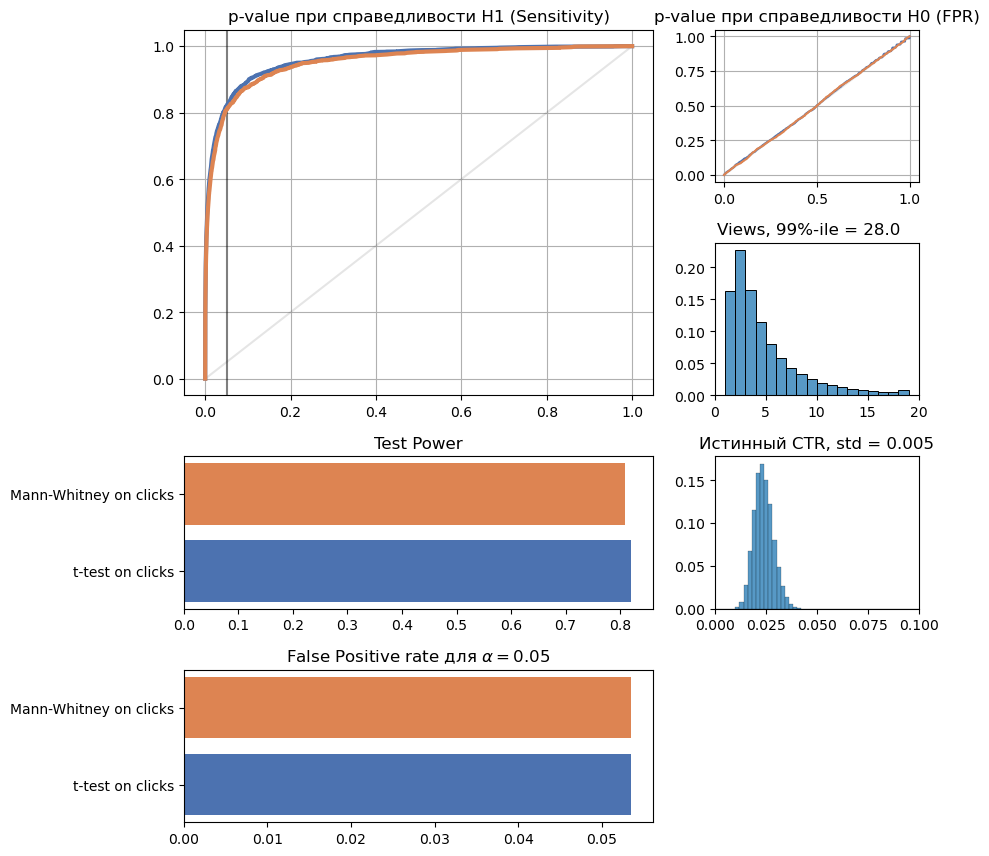

In [101]:
for beta in [1, 5, 10, 30, 50, 75, 100, 200, 300, 500, 1000]:
    views_a_1, views_a_2, views_b,\
    success_rate_a_1, success_rate_a_2,success_rate_b,\
    clicks_a_1, clicks_a_2, clicks_b = generation(sigma2 = 1, beta = beta)
    titles = ['t-test on clicks', 'Mann-Whitney on clicks']

    p_values_ab = [t_test(clicks_a_1, clicks_b),mannwhitney(clicks_a_1, clicks_b)]
    p_values_aa = [t_test(clicks_a_1, clicks_a_2),mannwhitney(clicks_a_1, clicks_a_2)]

    views_target = views_b
    ground_truth_ctr_target = success_rate_b 
    color = colors[0]

    test_data = {}
    for i,j in enumerate(titles):
        test_data[j] = (p_values_ab[i],p_values_aa[i],colors[i])
    pict = plot_summary(test_data,ground_truth_ctr_target,views_target)
    name = f'experimens={2000}_sample_size={5000}_uplift={0.2}_success_rate={0.02}_beta={beta}_skew={1}.png'
    pict.savefig(f'{name}')

In [104]:
x = 'experimens=2000_sample_size=5000_uplift=0.2_success_rate=0.02_beta=1000_skew=1.png'

In [29]:
import re

gif_list = sorted([i for i in os.listdir() if '.png' in i and 'exp' in i],
                 key=lambda x: int(re.search(r'(?<=beta=)\d+',x).group(0)),
                 reverse = True)


In [116]:
to_gif(gif_list, 't_test_and_Mann_Whitney_beta_variation.gif')
del_png(gif_list)

<img src="t_test_and_Mann_Whitney_beta_variation.gif" width="800">

# Тесты CTR

Намного чаще чем "просто клики" для тестирования используются показатели CTR, то есть:

$$CTR = \dfrac{\sum_{u \in Users}clicks_u}{\sum_{u \in Users}views_u}$$
\
Направление изменения общегруппового CTR такое же, как и направление изменения суммы кликов, если мы не влияем на показатель просмотров в нашем эксперименте. Это разумное предположением, если вы работаете, например, с таргетингом рекламного баннера на главной странице вашего сайта. Крайне маловероятно, что, изменив баннер, мы изменим среднее количество раз, которое пользователь видит его, поскольку это зависит от количества посещений главной страницы. Утверждение точно выполняется "не всегда", например оно может быть неверным для ранжирования ленты новостей, потому что более высокий рейтинг увеличивает вовлеченность пользователей и они склонны чаще посещать новостную ленту.

# [Бутстреп](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Bootstrap_hypothesis_testing) для CTR

Предположение:
* Мы не влияем на просмотры

Как видно из предыдущего раздела, нельзя использовать биномиальный z-тест для глобального CTR. Часто тут применияется бутстреп. Мы делаем выборки пользователей с возвращением и вычисляем глобальный CTR для каждой выборки. Затем мы используем полученное распределение статистики по бутстрепированным выборкам для построения доверительных интервалов и выполнения статистических тестов.

Бутстреп с большими данными работает довольно долго. В нашем случае мы можем применить бутстреп [Пуассона](http://www.unofficialgoogledatascience.com/2015/08/an-introduction-to-poisson-bootstrap26.html). 

Идея проста: вместо выборки пользователей c возвращением мы сэмплируем количество раз, которое каждый пользователь появляется в выборке из распределения Пуассона. Затем мы взвешиваем просмотры и клики с этим числом. Тут мы используем технику Пуассоновского бутстрепа для ускорения вычислений.

Глобальный CTR может быть выражен как средневзвешенное значение CTR пользователей, при этом CTR каждого пользователя взвешивается по количеству просмотров.

$$CTR = \dfrac{\sum_{u \in Users}clicks_u}{\sum_{u \in Users}views_u} = \dfrac{\sum_{u \in Users}views_u*User\_CTR_u}{\sum_{u \in Users}views_u}$$

# DISCLAIMER:

Бутстреп - очень долгая процедура. 

In [113]:
def bootstrap(ctrs_0, weights_0, ctrs_1, weights_1, n_bootstrap=2000):
    """
    Считает взвешенный bootstrap и вычисляет p-value по распределению статистик из псевдовыборок
    :param ctrs_0: np.array вида (n_experiments, n_users), 
        CTR каждого пользователя из контрольной группы в каждом эксперименте 
        
    :param weights_0: np.array (n_experiments, n_users), 
        вес каждого пользователя из контрольной группы в каждом эксперименте 
        
    :param ctrs_1: np.array (n_experiments, n_users), 
        CTR каждого пользователя из целевой группы в каждом эксперименте 
        
    :param weights_1: np.array (n_experiments, n_users), 
        вес каждого пользователя из целевой группы в каждом эксперименте 
        
    :param n_bootstrap: int - кол-во бутстрапированных псевдовыборок для каждого эксперимента
    :return: np.array shape (n_experiments), двусторонние p-value
    """
    poisson_bootstraps = scipy.stats.poisson(1).rvs(
        (n_bootstrap, ctrs_0.shape[1])).astype(np.int64)

    values_0 = np.matmul(ctrs_0 * weights_0, poisson_bootstraps.T)
    weights_0 = np.matmul(weights_0, poisson_bootstraps.T)

    values_1 = np.matmul(ctrs_1 * weights_1, poisson_bootstraps.T)
    weights_1 = np.matmul(weights_1, poisson_bootstraps.T)

    deltas = values_1 / weights_1 - values_0 / weights_0

    positions = np.sum(deltas < 0, axis=1)

    return 2 * np.minimum(positions, n_bootstrap - positions) / n_bootstrap

# Сейчас сделаем глубокий вдох и сгенерируем выборки для наших тестов

(Иначе будем каждый раз ждать до потери сознания)
Сохраним их и в дальнейшем вы сами сможете их покрутить. Только заметьте, что занимают эти выборки немало места (9 выборок для каждого набора параметров ~ 750 МБ). Подумайте, как можно генерировать поменьше или сохранять поэкономнее.

In [184]:
import os

# Сейчас будет выглядеть оооооооочень некрасиво
lst = []
for sigma2 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4, 1.5, 1.7, 1.9, 2, 2.2, 2.5, 2.7, 3, 3.5, 4, 4.5]:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={1000}/skew={sigma2}'
    os.makedirs(folder_path, exist_ok=True)
    print('sigma2 = ', sigma2, ' in progress')

    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = generation(sigma2=sigma2)

    np.save(folder_path+'/views_a_1.npy', views_a_1)
    np.save(folder_path+'/views_a_2.npy', views_a_2)
    np.save(folder_path+'/views_b.npy', views_b)

    np.save(folder_path+'/success_rate_a_1.npy', success_rate_a_1)
    np.save(folder_path+'/success_rate_a_2.npy', success_rate_a_2)
    np.save(folder_path+'/success_rate_b.npy', success_rate_b)

    np.save(folder_path+'/clicks_a_1.npy', clicks_a_1)
    np.save(folder_path+'/clicks_a_2.npy', clicks_a_2)
    np.save(folder_path+'/clicks_b.npy', clicks_b)

for beta in [1, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100, 125, 150, 175, 200, 300, 400, 500, 700, 1000, 1500, 2000]:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={beta}/skew={1}'
    os.makedirs(folder_path, exist_ok=True)
    print('beta = ', beta, ' in progress')

    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = generation(sigma2=1, beta=beta)

    np.save(folder_path+'/views_a_1.npy', views_a_1)
    np.save(folder_path+'/views_a_2.npy', views_a_2)
    np.save(folder_path+'/views_b.npy', views_b)

    np.save(folder_path+'/success_rate_a_1.npy', success_rate_a_1)
    np.save(folder_path+'/success_rate_a_2.npy', success_rate_a_2)
    np.save(folder_path+'/success_rate_b.npy', success_rate_b)

    np.save(folder_path+'/clicks_a_1.npy', clicks_a_1)
    np.save(folder_path+'/clicks_a_2.npy', clicks_a_2)
    np.save(folder_path+'/clicks_b.npy', clicks_b)

sigma2 =  0.1  in progress
sigma2 =  0.2  in progress
sigma2 =  0.3  in progress
sigma2 =  0.4  in progress
sigma2 =  0.5  in progress
sigma2 =  0.7  in progress
sigma2 =  0.9  in progress
sigma2 =  1.0  in progress
sigma2 =  1.2  in progress
sigma2 =  1.4  in progress
sigma2 =  1.5  in progress
sigma2 =  1.7  in progress
sigma2 =  1.9  in progress
sigma2 =  2  in progress
sigma2 =  2.2  in progress
sigma2 =  2.5  in progress
sigma2 =  2.7  in progress
sigma2 =  3  in progress
sigma2 =  3.5  in progress
sigma2 =  4  in progress
sigma2 =  4.5  in progress
beta =  1  in progress
beta =  5  in progress
beta =  10  in progress
beta =  20  in progress
beta =  30  in progress
beta =  40  in progress
beta =  50  in progress
beta =  60  in progress
beta =  75  in progress
beta =  90  in progress
beta =  100  in progress
beta =  125  in progress
beta =  150  in progress
beta =  175  in progress
beta =  200  in progress
beta =  300  in progress
beta =  400  in progress
beta =  500  in progress
b

# Вспомним, какие тесты мы с вами разобрали:

* t-тест
* Тест Манна-Уитни на кликах
* Пуассоновский бутстреп для группового CTR

А теперь давайте подсчитаем списки p-value для A/A и A/B тестов каждым из этих методов и сохраним в соответствующие папки. Чтобы, например, тяжелый бутстреп 125 раз не пересчитывать.

In [114]:
for beta in [1, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100, 125, 150, 175, 200, 300, 400, 500, 700, 1000, 1500, 2000]:
    print('beta = ', beta,' in progress')
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={beta}/skew={1}'
    views_a_1 = np.load(folder_path+'/views_a_1.npy')
    views_a_2 = np.load(folder_path+'/views_a_2.npy')
    views_b = np.load(folder_path+'/views_b.npy')

    success_rate_a_1 = np.load(folder_path+'/success_rate_a_1.npy')
    success_rate_a_2 = np.load(folder_path+'/success_rate_a_2.npy')
    success_rate_b = np.load(folder_path+'/success_rate_b.npy')

    clicks_a_1 = np.load(folder_path+'/clicks_a_1.npy')
    clicks_a_2 = np.load(folder_path+'/clicks_a_2.npy')
    clicks_b = np.load(folder_path+'/clicks_b.npy')

    # Считаем CTR для групп
    global_ctr_a1 = clicks_a_1.sum(axis=1) / views_a_1.sum(axis=1)
    global_ctr_a2 = clicks_a_2.sum(axis=1) / views_a_2.sum(axis=1)
    global_ctr_b = clicks_b.sum(axis=1) / views_b.sum(axis=1)

    # Считаем p-value A/B
    p_values_ab_t_test = t_test(clicks_a_1, clicks_b)
    p_values_ab_mann_whitney = mannwhitney(clicks_a_1, clicks_b)
    p_values_ab_bootstrap = bootstrap(clicks_a_1 / views_a_1, views_a_1, clicks_b / views_b, views_b)

    
    # Считаем p-value A/A
    p_values_aa_t_test = t_test(clicks_a_1, clicks_a_2)
    p_values_aa_mann_whitney = mannwhitney(clicks_a_1, clicks_a_2)
    p_values_aa_bootstrap = bootstrap(clicks_a_1 / views_a_1, views_a_1, clicks_a_2 / views_a_2, views_a_2)
    
    # Сохраняем
    np.save(folder_path+'/p_values_ab_t_test.npy', p_values_ab_t_test)
    np.save(folder_path+'/p_values_ab_mann_whitney.npy', p_values_ab_mann_whitney)
    np.save(folder_path+'/p_values_ab_bootstrap.npy', p_values_ab_bootstrap)
    
    np.save(folder_path+'/p_values_aa_t_test.npy', p_values_aa_t_test)
    np.save(folder_path+'/p_values_aa_mann_whitney.npy', p_values_aa_mann_whitney)
    np.save(folder_path+'/p_values_aa_bootstrap.npy', p_values_aa_bootstrap)
    
for sigma2 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4, 1.5, 1.7, 1.9, 2, 2.2, 2.5, 2.7, 3, 3.5, 4, 4.5]:
    print('sigma2 = ', sigma2,' in progress')
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={1000}/skew={sigma2}'
    views_a_1 = np.load(folder_path+'/views_a_1.npy')
    views_a_2 = np.load(folder_path+'/views_a_2.npy')
    views_b = np.load(folder_path+'/views_b.npy')

    success_rate_a_1 = np.load(folder_path+'/success_rate_a_1.npy')
    success_rate_a_2 = np.load(folder_path+'/success_rate_a_2.npy')
    success_rate_b = np.load(folder_path+'/success_rate_b.npy')

    clicks_a_1 = np.load(folder_path+'/clicks_a_1.npy')
    clicks_a_2 = np.load(folder_path+'/clicks_a_2.npy')
    clicks_b = np.load(folder_path+'/clicks_b.npy')

    # Считаем CTR для групп
    global_ctr_a1 = clicks_a_1.sum(axis=1) / views_a_1.sum(axis=1)
    global_ctr_a2 = clicks_a_2.sum(axis=1) / views_a_2.sum(axis=1)
    global_ctr_b = clicks_b.sum(axis=1) / views_b.sum(axis=1)

    # Считаем p-value A/B
    p_values_ab_t_test = t_test(clicks_a_1, clicks_b)
    p_values_ab_mann_whitney = mannwhitney(clicks_a_1, clicks_b)
    p_values_ab_bootstrap = bootstrap(clicks_a_1 / views_a_1, views_a_1, clicks_b / views_b, views_b)

    
    # Считаем p-value A/A
    p_values_aa_t_test = t_test(clicks_a_1, clicks_a_2)
    p_values_aa_mann_whitney = mannwhitney(clicks_a_1, clicks_a_2)
    p_values_aa_bootstrap = bootstrap(clicks_a_1 / views_a_1, views_a_1, clicks_a_2 / views_a_2, views_a_2)
    
    # Сохраняем
    np.save(folder_path+'/p_values_ab_t_test.npy', p_values_ab_t_test)
    np.save(folder_path+'/p_values_ab_mann_whitney.npy', p_values_ab_mann_whitney)
    np.save(folder_path+'/p_values_ab_bootstrap.npy', p_values_ab_bootstrap)
    
    np.save(folder_path+'/p_values_aa_t_test.npy', p_values_aa_t_test)
    np.save(folder_path+'/p_values_aa_mann_whitney.npy', p_values_aa_mann_whitney)
    np.save(folder_path+'/p_values_aa_bootstrap.npy', p_values_aa_bootstrap)

beta =  1  in progress
beta =  5  in progress
beta =  10  in progress
beta =  20  in progress
beta =  30  in progress
beta =  40  in progress
beta =  50  in progress
beta =  60  in progress
beta =  75  in progress
beta =  90  in progress
beta =  100  in progress
beta =  125  in progress
beta =  150  in progress
beta =  175  in progress
beta =  200  in progress
beta =  300  in progress
beta =  400  in progress
beta =  500  in progress
beta =  700  in progress
beta =  1000  in progress
beta =  1500  in progress
beta =  2000  in progress
sigma2 =  0.1  in progress
sigma2 =  0.2  in progress
sigma2 =  0.3  in progress
sigma2 =  0.4  in progress
sigma2 =  0.5  in progress
sigma2 =  0.7  in progress
sigma2 =  0.9  in progress
sigma2 =  1.0  in progress
sigma2 =  1.2  in progress
sigma2 =  1.4  in progress
sigma2 =  1.5  in progress
sigma2 =  1.7  in progress
sigma2 =  1.9  in progress
sigma2 =  2  in progress
sigma2 =  2.2  in progress
sigma2 =  2.5  in progress
sigma2 =  2.7  in progress
si

# Функции для загрузки полученных данных и сохранения p-value

In [30]:
# По этим спискам мы будем ходить

sigma_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0, 1.2,
              1.4, 1.5, 1.7, 1.9, 2, 2.2, 2.5, 2.7, 3, 3.5, 4, 4.5]
beta_list = [1, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100,
                     125, 150, 175, 200, 300, 400, 500, 700, 1000, 1500, 2000]


def data_loader(folder_path):

    views_a_1 = np.load(folder_path+'/views_a_1.npy')
    views_a_2 = np.load(folder_path+'/views_a_2.npy')
    views_b = np.load(folder_path+'/views_b.npy')

    success_rate_a_1 = np.load(folder_path+'/success_rate_a_1.npy')
    success_rate_a_2 = np.load(folder_path+'/success_rate_a_2.npy')
    success_rate_b = np.load(folder_path+'/success_rate_b.npy')

    clicks_a_1 = np.load(folder_path+'/clicks_a_1.npy')
    clicks_a_2 = np.load(folder_path+'/clicks_a_2.npy')
    clicks_b = np.load(folder_path+'/clicks_b.npy')

    return views_a_1, views_a_2, views_b,\
            success_rate_a_1, success_rate_a_2, success_rate_b,\
            clicks_a_1, clicks_a_2, clicks_b


def p_value_saver(folder_path, name, p_values_ab, p_values_aa):
    np.save(folder_path+'/p_values_ab_'+name+'.npy', p_values_ab)
    np.save(folder_path+'/p_values_aa_'+name+'.npy', p_values_aa)

## Рисуем одну картинку по готовым данным (возвращаем имя картинки)

In [31]:
def compare_tests(tests_list,
                  experiments=2000,
                  sample_size=5000,
                  uplift=0.2,
                  success_rate=0.02,
                  beta=1000,
                  sigma2=1):
    folder_path = f'test_data/experimens={experiments}/sample_size={sample_size}/uplift={uplift}/success_rate={success_rate}/beta={beta}/skew={sigma2}'
    _, _, views_b, _, _, success_rate_b, _, _, _ = data_loader(folder_path)
    
    p_values_ab, p_values_aa = [], []
    for title in tests_list:
        ab = np.load(folder_path+'/p_values_ab_'+title+'.npy')
        aa = np.load(folder_path+'/p_values_aa_'+title+'.npy')
        p_values_ab.append(ab)
        p_values_aa.append(aa)

    views_target = views_b
    ground_truth_ctr_target = success_rate_b
    color = colors[0]

    test_data = {}
    for i, j in enumerate(tests_list):
        test_data[j] = (p_values_ab[i], p_values_aa[i], colors[i+1])
    pict = plot_summary(test_data, ground_truth_ctr_target, views_target)
    name = f'{folder_path}.png'.replace('/','_')
    
    pict.savefig(f'test_data/{name}')
    return name

## Собираем графики для $\sigma$ в gif

In [32]:
png_list = []
for sigma in sigma_list:
    png_list.append(compare_tests(
        ['t_test','mann_whitney', 'bootstrap'], sigma2=sigma))


In [35]:
to_gif(['test_data/'+i for i in png_list] , 'delta_skew_webinar2.gif')

<img src="delta_skew_webinar2.gif" width="800">

## Собираем графики для $\beta$ в gif

In [36]:
png_list = []
for _beta in beta_list:
    png_list.append(compare_tests(
        ['t_test','mann_whitney', 'bootstrap'], beta=_beta))

In [37]:
os.chdir('test_data')
to_gif(png_list, 'delta_beta_webinar1.gif')

<img src="test_data/delta_beta_webinar1.gif" width="800">

# Бакетное преобразование

Предположение:
* Мы не влияем на просмотры

Еще один подход, который очень часто применяется - бакетное преобразование. Надо разбить пользователей на n "корзинок" ("бакетов"). Нужно гарантировать, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. Это можно гарантировать с помощью техники хеширования с солью. О применении такого в Авито можно прочитать [тут](https://habr.com/ru/company/avito/blog/454164/). Каждый бакет теперь становится как бы "метапользователем", участвующим в эксперименте. И внутри такого "метапользователя" показатель нужно как-то агрегировать. Обычно вычисляют среднюю метрику в бакете, но можно, например, подсчитать медиану. Скажем, если у нас 100 бакетов для теста и контроля, получается будто мы тест проводим на группах по 100 пользователей в каждой :)

Поверх бакетного преобразования можно, например, применить стандартный t-тест (если +- выполнены его предположения) или тест Манна-Уитни.




In [63]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return values_0, values_1

In [64]:
# t-тест поверх бакетов
def t_test_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=50):
    return t_test(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

# тест Манна-Уитни поверх бакетов
def mannwhitney_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=50):
    return mannwhitney(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

Варьируем $\sigma$

In [54]:
os.chdir('Karpov Statistics')

In [55]:
os.getcwd()

'/Users/i.pile/Karpov Statistics'

In [179]:
for sigma2 in sigma_list:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={1000}/skew={sigma2}'
    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = data_loader(folder_path)
    
    p_values_aa = t_test_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_a_2 / views_a_2, views_a_2)

    p_values_ab = t_test_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_b / views_b, views_b)
    
    p_value_saver(folder_path, 't_test_buckets', p_values_ab, p_values_aa)
    
    p_values_aa = mannwhitney_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_a_2 / views_a_2, views_a_2)

    p_values_ab = mannwhitney_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_b / views_b, views_b)
    
    p_value_saver(folder_path, 'mann_whitney_buckets', p_values_ab, p_values_aa)

In [56]:
png_list = []
for sigma in sigma_list:
    png_list.append(compare_tests(
        ['mann_whitney', 'bootstrap', 't_test_buckets','mann_whitney_buckets'], sigma2=sigma))

In [58]:
os.chdir('test_data')

In [59]:
to_gif(png_list, '../buckets_skew_webinar.gif')

<img src="buckets_skew_webinar.gif" width="800">

Варьируем $\beta$

In [61]:
for i in os.listdir():
    if 'png' in i:
        os.remove(i)
os.chdir('..')

In [187]:
for beta in beta_list:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={beta}/skew={1}'
    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = data_loader(folder_path)
    
    p_values_aa = t_test_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_a_2 / views_a_2, views_a_2)

    p_values_ab = t_test_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_b / views_b, views_b)
    
    p_value_saver(folder_path, 't_test_buckets', p_values_ab, p_values_aa)
    
    p_values_aa = mannwhitney_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_a_2 / views_a_2, views_a_2)

    p_values_ab = mannwhitney_buckets(
        clicks_a_1 / views_a_1, views_a_1,
        clicks_b / views_b, views_b)
    
    p_value_saver(folder_path, 'mann_whitney_buckets', p_values_ab, p_values_aa)

In [62]:
png_list = []
for beta in beta_list:
    png_list.append(compare_tests(
        ['mann_whitney', 'bootstrap', 't_test_buckets','mann_whitney_buckets'], beta=beta))

In [63]:
to_gif(['test_data/'+x for x in png_list], 'buckets_beta_webinar.gif')

<img src="buckets_beta_webinar.gif" width="800">

# Поюзерные метрики

Как видите, с общегрупповым CTR может быть непросто. Z-тест для них напрямую может не сработать, так как предположения Z-теста часто нарушаются. Поэтому мы и стали изобретать бутстреп и т.д. На самом деле мы можем ставить тесты над наблюдаемыми пользовательскими CTR. Кажется, что если средний поюзерный CTR увеличится, то увеличится и общее количество кликов, но это НЕ ТАК. Это будет так только при важном дополнении – поюзерный CTR и его uplift НЕ ЗАВИСИТ от просмотров.

На всякий случай, вот пример, когда среднего рост поюзерного CTR не приводит к росту кликов. 
Пусть в тестовой группе 100 человек: у 99 из них по 100 просмотров, а у одного – 100000. Пусть начальный CTR каждого пользователя составляет 2%. 

Увеличим CTR 99 пользователей (у которых по 100 просмотров) в 2 раза, а у пользователя с 100000 просмотров – уменьшим CTR в 2 раза. Средний CTR пользователя увеличится примерно в 2 раза, а общее количество кликов упадет, потому что почти все принес пользователь с 100000 просмотров. 

Если в ваших данных есть зависимость CTR пользователей от просмотров (например, более активные пользователи имеют существенно более высокий CTR), то для вас такие методы не подойдут.

Далее мы будем предполагать, что CTR пользователей (и uplift в CTR пользователей) и просмотры независимы.

# Перевзвешивание пользователей

Направление изменения общегруппового CTR совпадает с направлением изменения общего количества кликов, поскольку мы нашим экспериментом не влияем на просмотры. Если пользовательский CTR и его добавочное значение также не зависят от просмотров , изменение среднего CTR пользователя происходит в ту же сторону. Как мы могли заметить, тесты, работающие с общегрупповым CTR, намного мощнее, чем t-тест на CTR пользователей. Если присмотреться внимательно, то общегрупповой CTR - это средневзвешенное значение CTR пользователей с весом, равным просмотрам. Таким образом, взвешивая CTR пользователей с помощью просмотры, мы получаем существенный выигрыш в эффективности статистических тестов.
Но является ли взвешивание по просмотрам оптимальным выбором для статистического теста? Технически мы можем использовать любые веса, если они не зависят от CTR пользователей. Таким образом, мы можем взвесить CTR пользователей с любой положительной функцией просмотров (которые не нарушают предположения "CTR пользователя не зависит от просмотров"). Исследователи из eBay нашли наиболее эффективные теоретически обоснованные веса. Эти веса равны [эффективному количеству просмотров на пользователя](https://en.wikipedia.org/wiki/Effective_sample_size):

$$w_u = \dfrac{views_u}{1+\rho(views_u-1)}$$

где $views_u$ - это количество просмотров каждого пользователя, а $\rho$ - коэффициент "внутрипользовательской" корреляции (за подробностями [сюда](https://arxiv.org/abs/1911.03553), смотреть блок про UMVUE). Что это такое, можно увидеть непосредственно в коде. В статье исследователи показывают, что при рассмотрении последовательных визитов и кликов от одного и того же пользователя специальный способ перевзвешивания позволяет получить более точную несмещенную оценку, обладающую меньшей дисперсией :)

Так когда внутрипользовательская корреляция равна нулю, вес равен просмотрам, как в случае с глобальным CTR. Когда внутрипользовательская корреляция равна единице, все пользователи будут иметь одинаковый вес, равный единице, как в случае со средним CTR пользователя. В реальной жизни эта корреляция находится где-то между нулем и единицей и должна оцениваться для каждой метрики отдельно.
Мы применим эти веса к CTR пользователей и будем использовать их в бутстрепе (обратите внимание, что эти веса также можно использовать при разбиении по бакетам и линеаризации).

In [65]:
def intra_user_correlation_aware_weights(clicks_0, views_0, views_1):
    """
    Считаем веса с помощью UMVUE оценку CTR в тесте и контроле
    :param clicks_0: np.array размера (n_experiments, n_users), клики в контрольной группе
    :param views_0: np.array размера (n_experiments, n_users), просмотры из контроля
    :param views_1: np.array размера (n_experiments, n_users), просмотры из целевой группы
    :return: (np.array, np.array) размера (n_experiments, n_users), веса каждого пользователя
    """
    ri = clicks_0 / views_0
    s3 = clicks_0 * (1 - ri) ** 2 + (views_0 - clicks_0) * ri ** 2
    s3 = np.sum(s3, axis=1) / np.sum(views_0 - 1, axis=1)

    rb = np.mean(clicks_0 / views_0, axis=1).reshape(-1, 1)
    s2 = clicks_0 * (1 - rb) ** 2 + (views_0 - clicks_0) * rb ** 2
    s2 = np.sum(s2, axis=1) / (np.sum(views_0, axis=1) - 1)

    rho = np.maximum(0, 1 - s3 / s2).reshape(-1, 1)

    w_0 = views_0 / (1 + (views_0 - 1) * rho)
    w_1 = views_1 / (1 + (views_1 - 1) * rho)
    return w_0, w_1

In [246]:
for sigma2 in sigma_list:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={1000}/skew={sigma2}'
    print('Processing sigma2=',sigma2)
    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = data_loader(folder_path)

    corr_aware_w_aa_0, corr_aware_w_1_aa_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_a_2)
    corr_aware_w_ab_0, corr_aware_w_1_ab_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_b)
    
    p_values_aa_bootstrap_weighted = bootstrap(
        clicks_a_1 / views_a_1, corr_aware_w_aa_0, clicks_a_2 / views_a_2, corr_aware_w_1_aa_1)

    p_values_ab_bootstrap_weighted = bootstrap(
        clicks_a_1 / views_a_1, corr_aware_w_ab_0, clicks_b / views_b, corr_aware_w_1_ab_1)

    p_value_saver(folder_path, 'weighted_bootstrap',
                  p_values_ab_bootstrap_weighted, p_values_aa_bootstrap_weighted)

Processing sigma2= 0.1
Processing sigma2= 0.2
Processing sigma2= 0.3
Processing sigma2= 0.4
Processing sigma2= 0.5
Processing sigma2= 0.7
Processing sigma2= 0.9
Processing sigma2= 1.0
Processing sigma2= 1.2
Processing sigma2= 1.4
Processing sigma2= 1.5
Processing sigma2= 1.7
Processing sigma2= 1.9
Processing sigma2= 2
Processing sigma2= 2.2
Processing sigma2= 2.5
Processing sigma2= 2.7
Processing sigma2= 3
Processing sigma2= 3.5
Processing sigma2= 4
Processing sigma2= 4.5


In [65]:
for sigma2 in sigma_list:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={1000}/skew={sigma2}'
    print('Processing sigma2=',sigma2)
    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = data_loader(folder_path)

    corr_aware_w_aa_0, corr_aware_w_1_aa_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_a_2)
    corr_aware_w_ab_0, corr_aware_w_1_ab_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_b)
    
    p_values_aa = t_test_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_aa_0,
        clicks_a_2 / views_a_2, corr_aware_w_1_aa_1)

    p_values_ab = t_test_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_ab_0,
        clicks_b / views_b, corr_aware_w_1_ab_1)
    
    p_value_saver(folder_path, 't_test_weighted_buckets', p_values_ab, p_values_aa)
    
    p_values_aa = mannwhitney_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_aa_0,
        clicks_a_2 / views_a_2, corr_aware_w_1_aa_1)

    p_values_ab = mannwhitney_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_ab_0,
        clicks_b / views_b, corr_aware_w_1_ab_1)
    
    p_value_saver(folder_path, 'mann_whitney_weighted_buckets', p_values_ab, p_values_aa)

Processing sigma2= 0.1
Processing sigma2= 0.2
Processing sigma2= 0.3
Processing sigma2= 0.4
Processing sigma2= 0.5
Processing sigma2= 0.7
Processing sigma2= 0.9
Processing sigma2= 1.0
Processing sigma2= 1.2
Processing sigma2= 1.4
Processing sigma2= 1.5
Processing sigma2= 1.7
Processing sigma2= 1.9
Processing sigma2= 2
Processing sigma2= 2.2
Processing sigma2= 2.5
Processing sigma2= 2.7
Processing sigma2= 3
Processing sigma2= 3.5
Processing sigma2= 4
Processing sigma2= 4.5


In [67]:
png_list = []
for sigma in sigma_list:
    png_list.append(compare_tests(
        ['t_test_buckets','mann_whitney_buckets', 'bootstrap', 'weighted_bootstrap', 't_test_weighted_buckets','mann_whitney_weighted_buckets'], sigma2=sigma))
to_gif(['test_data/'+x for x in png_list], 'weighted_skew.gif')

<img src="weighted_skew.gif" width="800">

In [248]:
for beta in beta_list:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={beta}/skew={1}'
    
    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = data_loader(folder_path)

    corr_aware_w_aa_0, corr_aware_w_1_aa_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_a_2)
    corr_aware_w_ab_0, corr_aware_w_1_ab_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_b)
    
    p_values_aa_bootstrap_weighted = bootstrap(
        clicks_a_1 / views_a_1, corr_aware_w_aa_0, clicks_a_2 / views_a_2, corr_aware_w_1_aa_1)

    p_values_ab_bootstrap_weighted = bootstrap(
        clicks_a_1 / views_a_1, corr_aware_w_ab_0, clicks_b / views_b, corr_aware_w_1_ab_1)

    p_value_saver(folder_path, 'weighted_bootstrap',
                  p_values_ab_bootstrap_weighted, p_values_aa_bootstrap_weighted)

In [68]:
for beta in beta_list:
    folder_path = f'test_data/experimens={2000}/sample_size={5000}/uplift={0.2}/success_rate={0.02}/beta={beta}/skew={1}'
    
    views_a_1, views_a_2, views_b,\
        success_rate_a_1, success_rate_a_2, success_rate_b,\
        clicks_a_1, clicks_a_2, clicks_b = data_loader(folder_path)

    corr_aware_w_aa_0, corr_aware_w_1_aa_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_a_2)
    corr_aware_w_ab_0, corr_aware_w_1_ab_1 = intra_user_correlation_aware_weights(clicks_a_1, views_a_1,
                                                                                  views_b)
    
    p_values_aa = t_test_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_aa_0,
        clicks_a_2 / views_a_2, corr_aware_w_1_aa_1)

    p_values_ab = t_test_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_ab_0,
        clicks_b / views_b, corr_aware_w_1_ab_1)
    
    p_value_saver(folder_path, 't_test_weighted_buckets', p_values_ab, p_values_aa)
    
    p_values_aa = mannwhitney_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_aa_0,
        clicks_a_2 / views_a_2, corr_aware_w_1_aa_1)

    p_values_ab = mannwhitney_buckets(
        clicks_a_1 / views_a_1, corr_aware_w_ab_0,
        clicks_b / views_b, corr_aware_w_1_ab_1)
    
    p_value_saver(folder_path, 'mann_whitney_weighted_buckets', p_values_ab, p_values_aa)

In [69]:
png_list = []
for beta in beta_list:
    png_list.append(compare_tests(
        ['mann_whitney', 'bootstrap', 'weighted_bootstrap', 't_test_weighted_buckets','mann_whitney_weighted_buckets'], beta=beta))
to_gif(['test_data/'+x for x in png_list], 'weighted_bootstrap_beta.gif')

<img src="weighted_bootstrap_beta.gif" width="800">

# Общие выводы

Для вашей задачи можно сгенерировать синтетические данные, которые похожи на ваши, и проверить качество тестов, которые мы обсуждали. При этом важно помнить о предположениях, которые делают тесты, поскольку они очень важны.

Если не хочется долго крутить (а я очень рекомендую это делать), вот некоторый список правил.

* Независимо от того, какой тест вы выберете, всегда проверяйте его количество ложных срабатываний при справедливости H0. Самый простой способ сделать это - запустить один A / A-тест и собрать из него метрики. Затем вы можете сгенерировать из него бесконечное количество A / A-тестов, случайным образом разделив пользователей на две группы. Нужно, чтобы результат CDF стремился к диагонали.

При выборе теста сначала следует проверить дополнительные предположения:

* Ваш эксперимент не влияет на просмотры.
* CTR пользователей в ваших данных не зависит от просмотров, и разница в CTR между группами (эффект вашего эксперимента) тоже не зависит от просмотров.